In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.sparse import hstack
import eli5

In [ ]:
df = pd.read_csv(
    '/kaggle/input/real-time-advertisers-auction/Dataset.csv', 
#      parse_dates=['date'],
)
print(df.shape)
df.head(2)

In [ ]:
# Check feature redundancy
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(data=corr,vmin=0, vmax=1, cmap="YlGnBu",  square=True, annot=True, fmt=".2f")
plt.show()

In [ ]:
# some features are constant
df.std().sort_values().reset_index().T

In [ ]:
# drop useless features
useless_cols = [
    'integration_type_id' ,  # no variance
    'revenue_share_percent', # no variance
    'total_impressions',     # full correlation with measurable_impressions
]
df.drop(useless_cols, axis=1, inplace=True)

# add day_of_week feature
df['date'] = pd.to_datetime(df.date)
df['day_of_week'] = df.date.apply(lambda x: x.dayofweek)


def weird_division(n, d):
    return n / d if d else 0


df['CPM'] = df.apply(lambda x: weird_division(x['total_revenue'] * 100,
                                              x['measurable_impressions']) * 1000 , axis=1)

# drop outliers
df = df[df['CPM'].between(0, df['CPM'].quantile(.95))]

# drop leaking features
leaking_cols = ['total_revenue', 'measurable_impressions']
df.drop(leaking_cols, axis=1, inplace=True)
# scale only numeric feature
df['viewable_impressions'] = (df['viewable_impressions'] -
                              df['viewable_impressions'].mean()) / df['viewable_impressions'].std()

In [ ]:
corr = df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(data=corr,vmin=0, vmax=1, cmap="YlGnBu",  square=True, annot=True, fmt=".2f")
plt.show()

In [ ]:
# train-test split
test_df = df[df.date >= "2019-06-22"].drop(['date', 'CPM'], axis=1)
test_y = df[df.date >= "2019-06-22"]['CPM']

train_df = df[df.date < "2019-06-22"].drop(['date'], axis=1)

In [ ]:
cat_features = [
    'site_id', 'ad_type_id',
    'geo_id', 'device_category_id',
    'advertiser_id',
    'order_id', 'os_id',
    'line_item_type_id',
    'monetization_channel_id', 
    'ad_unit_id', 'day_of_week',
]
num_features = ['viewable_impressions']

assert len(cat_features) + len(num_features) == train_df.shape[1] - 1 == test_df.shape[1]

In [ ]:
# encode categorical features
ohe = OneHotEncoder(handle_unknown='ignore', dtype=np.uint8)
X = ohe.fit_transform(train_df[cat_features])
X_test = ohe.transform(test_df[cat_features])
y = train_df.CPM

# add numeric feature
X_extended = hstack([X, train_df[num_features]], dtype=np.float32).tocsr()
X_test_extended = hstack([X_test, test_df[num_features]], dtype=np.float32).tocsr()

assert X.shape[1] == X_test.shape[1] == train_df[cat_features].nunique().sum()

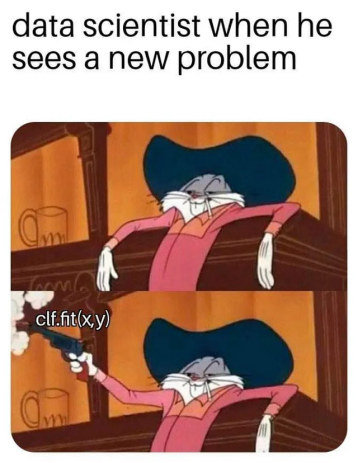

In [ ]:
# call regressor "clf" out of habit... clf is regressor!
fast_clfs = [
    LinearRegression(), # good
    Lasso(.1),          # not bad
    Lasso(.5),
    Lasso(1.),
    ElasticNet(alpha=1, l1_ratio=0.7),
    ElasticNet(alpha=1, l1_ratio=0.2),
    ElasticNet(alpha=.5, l1_ratio=0.7),
    ElasticNet(alpha=.5, l1_ratio=0.2),
]

for clf in fast_clfs:
    scores = cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    print(repr(clf), -np.round(scores, 2))

### Simple `LinearRegression` is the best of best

In [ ]:
clf = LinearRegression()
clf.fit(X, y)
y_pred = clf.predict(X_test)
final_score = mean_squared_error(test_y, y_pred)
print(f"final CPM prediction score = {final_score:.2f}")

## We didn't use single numeric feature, because:
- score is already good
- with this feature X-matrix will be converted to float dtype and training time will increase. Don't want to wait...
- it is useless

## Model interpretation

In [ ]:
ohe_features = ohe.get_feature_names(cat_features)
eli5.show_weights(clf, top=30, feature_names=ohe_features)

### We can see that `order_id` is the most valuable feature